#  **ICT303 - Assignment 1**

**Your name: Caleb Goss**

**Student ID: 34090158**

**Email: cjmeepers@gmail.com**






## **1. Description**

In this homework, you will build, train, test and compare the performance of multilayer perceptrons (MLP) and convolutional neural networks (CNNs) on a multi-class classification problem.

For this task, you will use the image dataset available [here](https://drive.google.com/file/d/1nWRm-Npq_QE0j_sHyVVxVEx2Rb0Lc1zU/view?usp=sharing). This dataset contains 8 categories of images distributed as shown in the following structure (in total 22 directories):




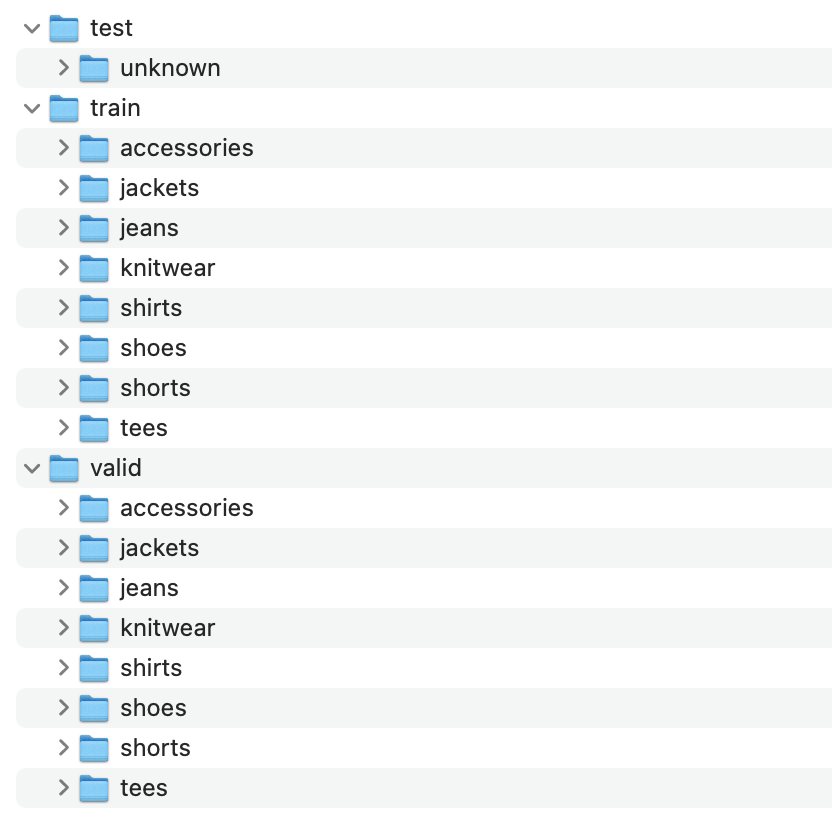


Your task is to:
1. Develop a multilayer perceptron model, train it and test it on the dataset. You need to finetune the hyperparameters to select those that provide the best performance. **[40 Marks]**
2. Implement VGG16, which a CNN architecture, train it and test it on the dataset. You must NOT use the pre-implemented VGG16 network in Pytorch. Instead, you have to implement all the layers and blocks yourself from scratch. You need to finetune the hyperparameters to select those that provide the best performance. **[40 Marks]**
3. Repeat step 2 above , but this time using the pretrained VGG16 network of PyTorch. **[20 Marks]**
4. For each of the tasks above, you need to finetune the hyper parameters to achieve the best performance possible.
5. Compare the performance of the three models.

It is important that you start as earlier as possible. Tuning hyper-parameters takes time, and Kaggle limits the number of submissions per day.

For Perth campus students, enrolled in internal model, you will be required to demonstrate your work in class. External students may be called to demonstrate the work to their tutor.

## **2. What do you need to submit**

You must submit:
- your source code, in the form of python libraries (i.e., .py files)
- A colab notebook that
 - Describes your solution and design choices. It is highly recommended to visually show the architecture of the networks you developed. You must include a discussion on how the hyper parameters affect performance and how did you select the ones you are currently using.
 - Demonstrates the training and testing of the machine learning models you developed.
 - Plots the training and validation curves for each model. You are requried to use TensorBoard for this task.
 - Analyzes the performance, in terms of Confusion Matrix and Mean Average Precision (MAE), of the methods, and how the hyper parameters affect this performance.
 - Allows the visualization of some classification results.

Important notes
- The performance of the machine learning models can be significantly affected by (1) the amount of data on which they are trained, and (2) preprocessing, such as normalization, of the data (I will talk about this in class).
- Your program must be structured following what we have seen in the labs. In other words, you must use Object-oriented Programming and have a class for the data, a class for the model, a class for the trainer. You are allowed to reuse code you create in the labs. Also, you are allowed (in fact sometimes you should) reuse code across different models. For example, you only need one class to manage the data, whether you are using MLPs or CNNs (VGG16 in our case).
- We have zero tolerance for plagaiarsism and misconduct (e.g., asking AI to do the work for you).

Almost all model training and evaluation has been ran locally on my laptop (Google Colab with T4 GPU is used sometimes).

I am able to take advantage of CUDA functionality to assist in speeding up the process of training.

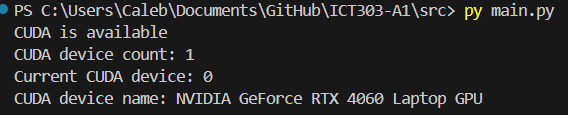

I've tested various hyperparameters and models to ensure the optimal performance for each model type. (I should've smoothed the curves)

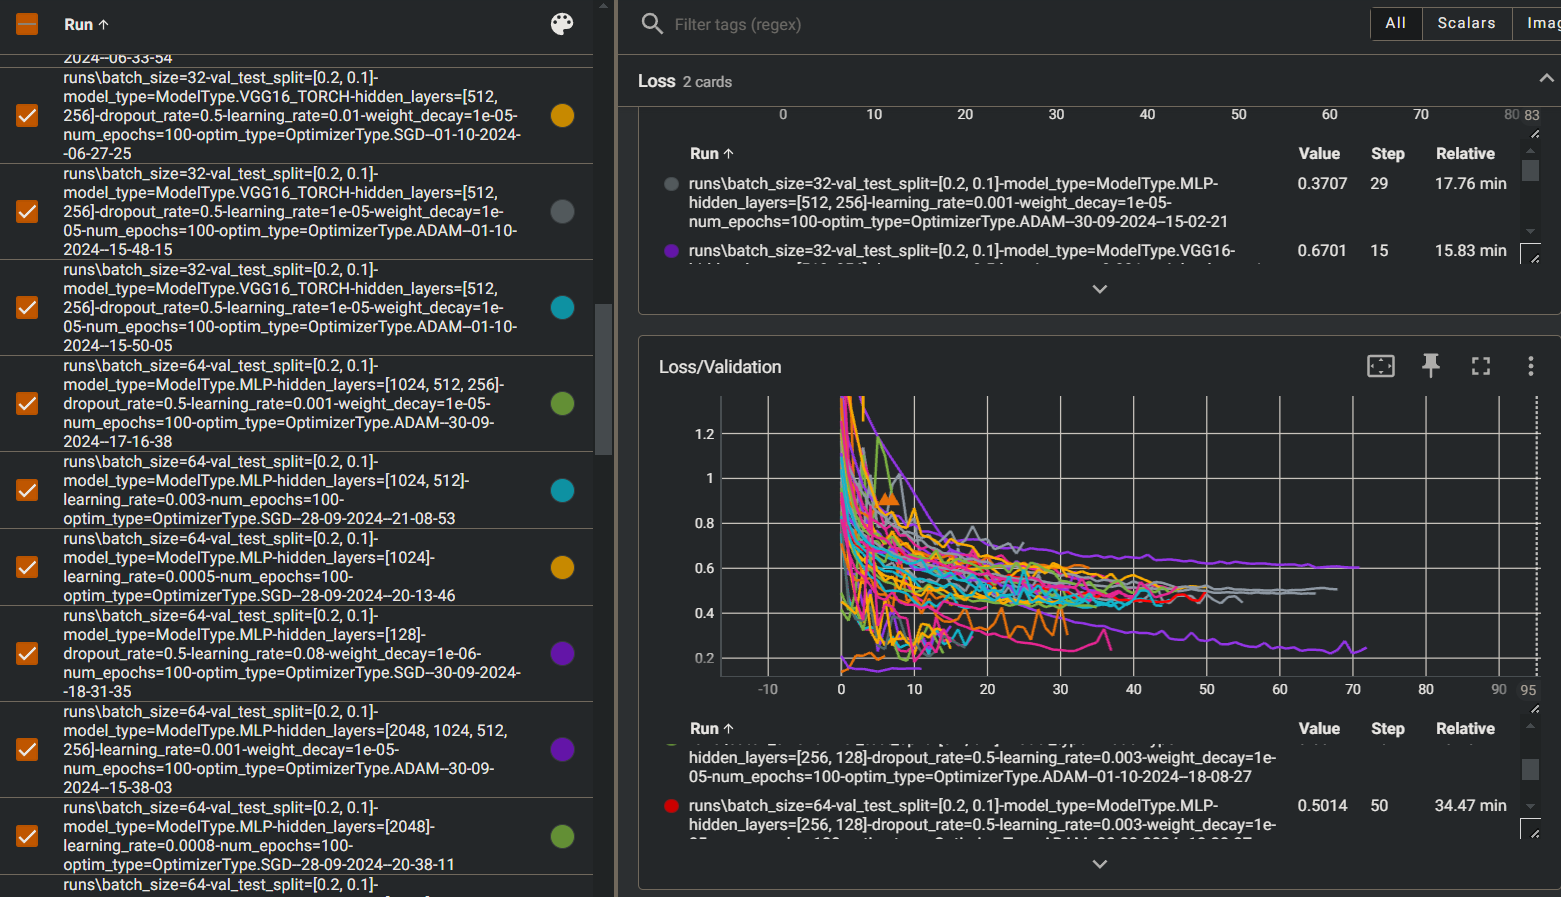

## Info on training, validation, and testing data



I used a 70/20/10 split for training, validation, and testing data respectively.

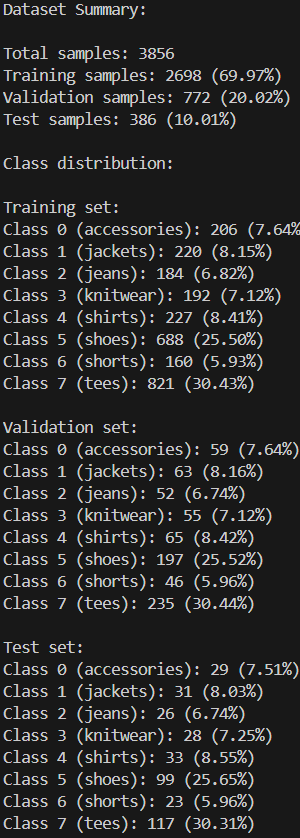

## Model summary of MLP model

![Screenshot 2024-10-01 181435.png](<attachment:Screenshot 2024-10-01 181435.png>)

![runs_batch_size=32-val_test_split=[0.2, 0.1]-model_type=ModelType.MLP-hidden_layers=[256, 128]-dropout_rate=0.5-learning_rate=0.01-weight_decay=1e-09-num_epochs=100-optim_type=OptimizerType.SGD--01.png](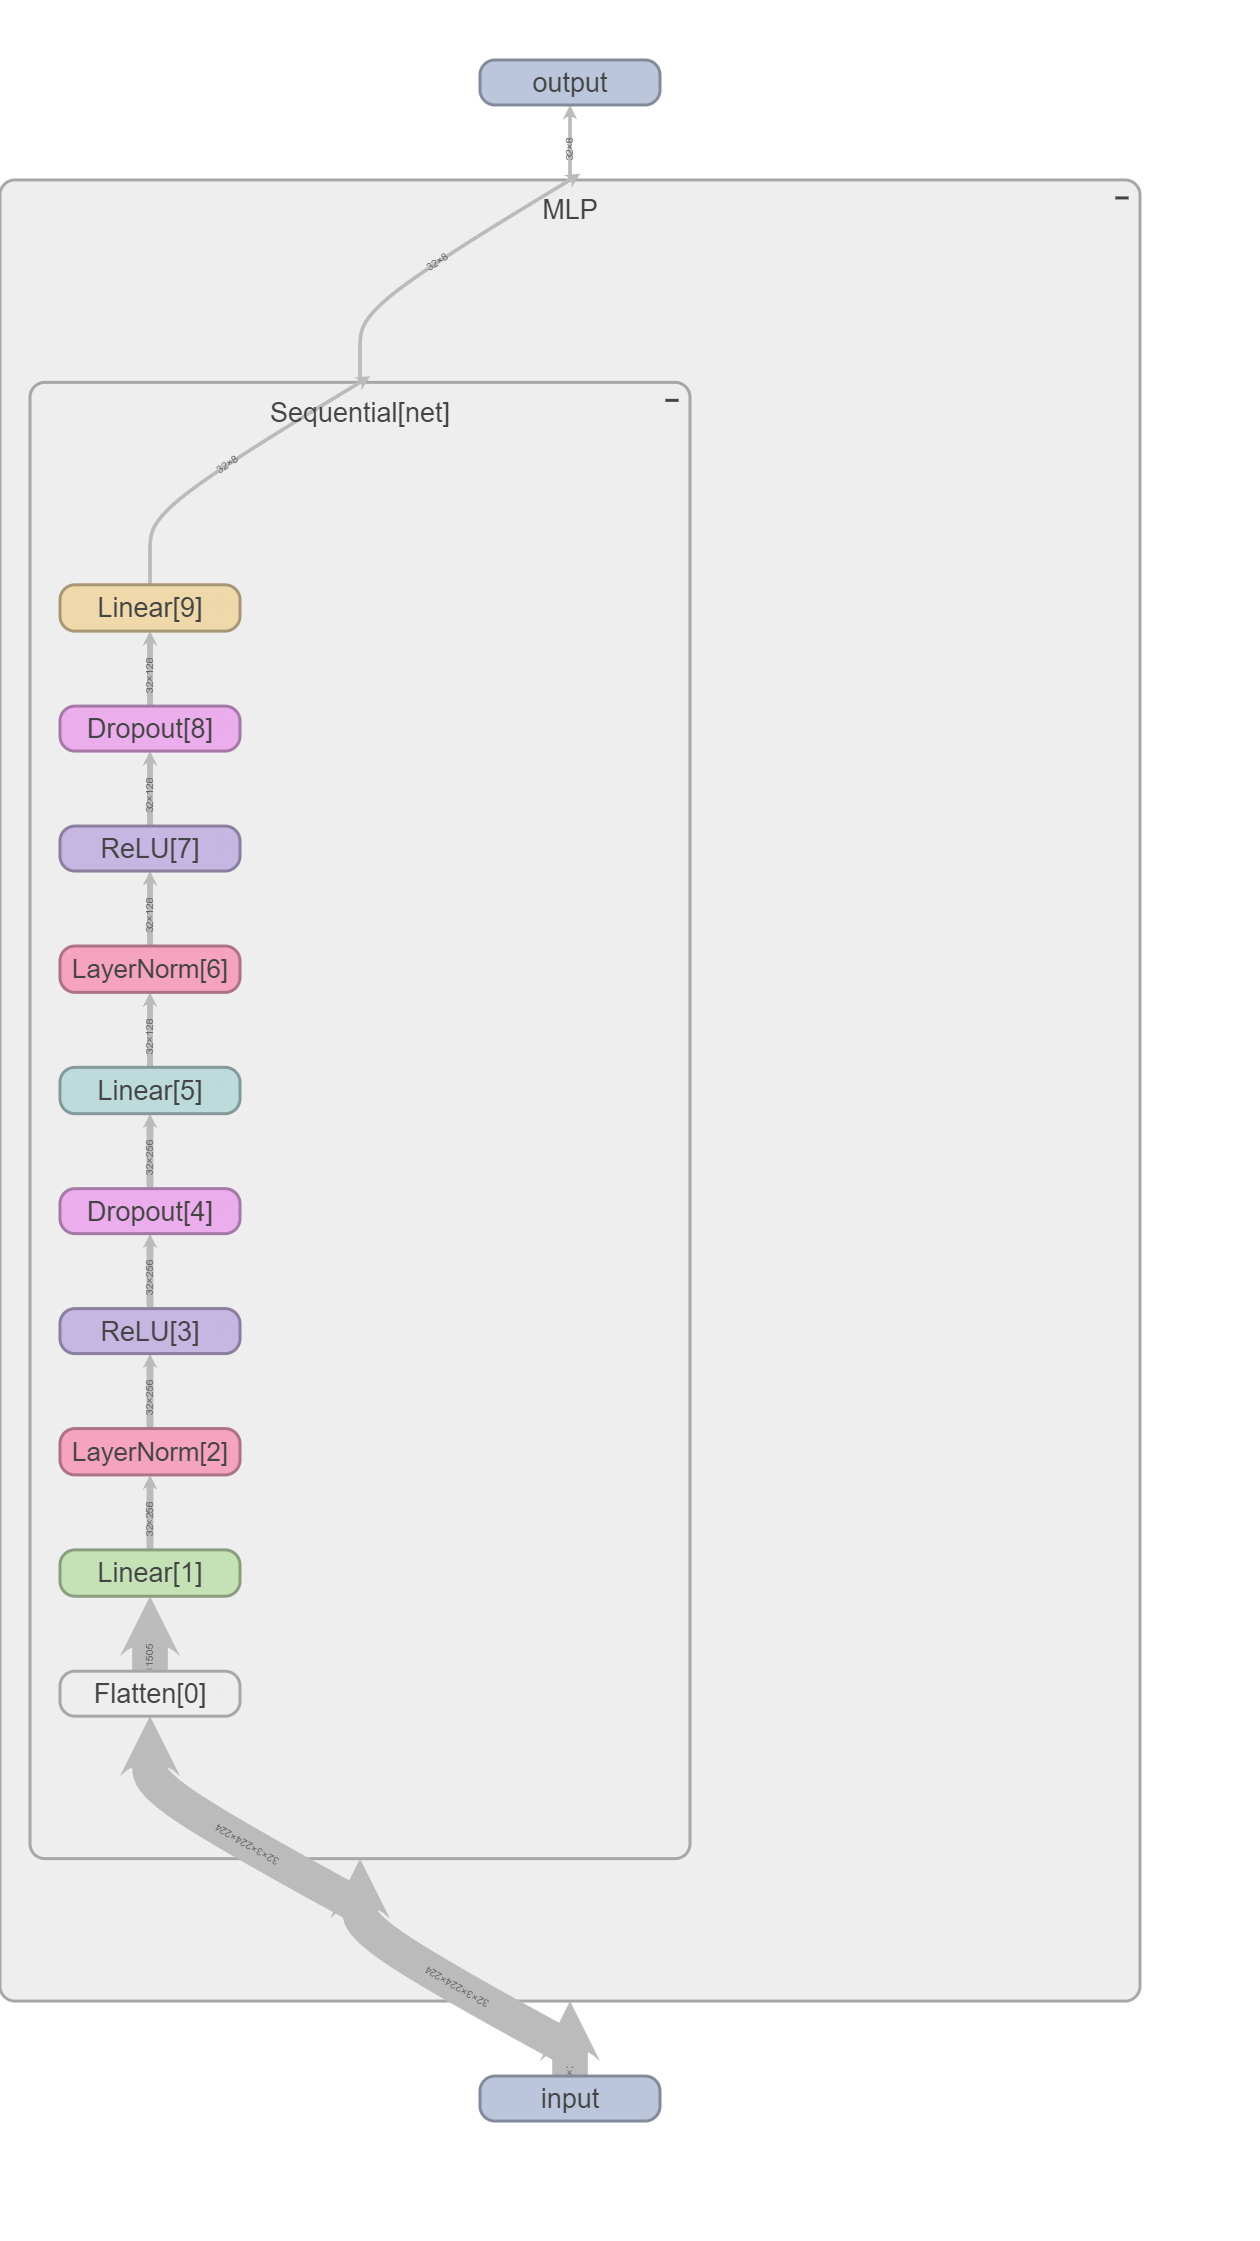)
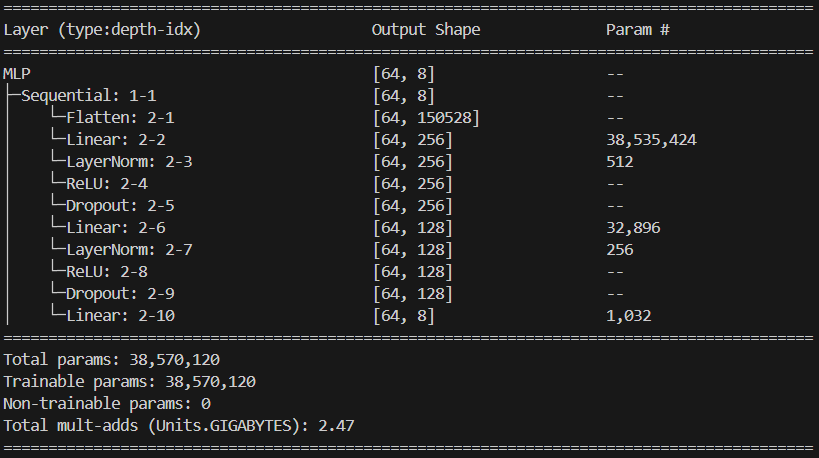

## Model summary of VGG16 model (from scratch)

##Model summary of VGG16 model (pytorch provided)



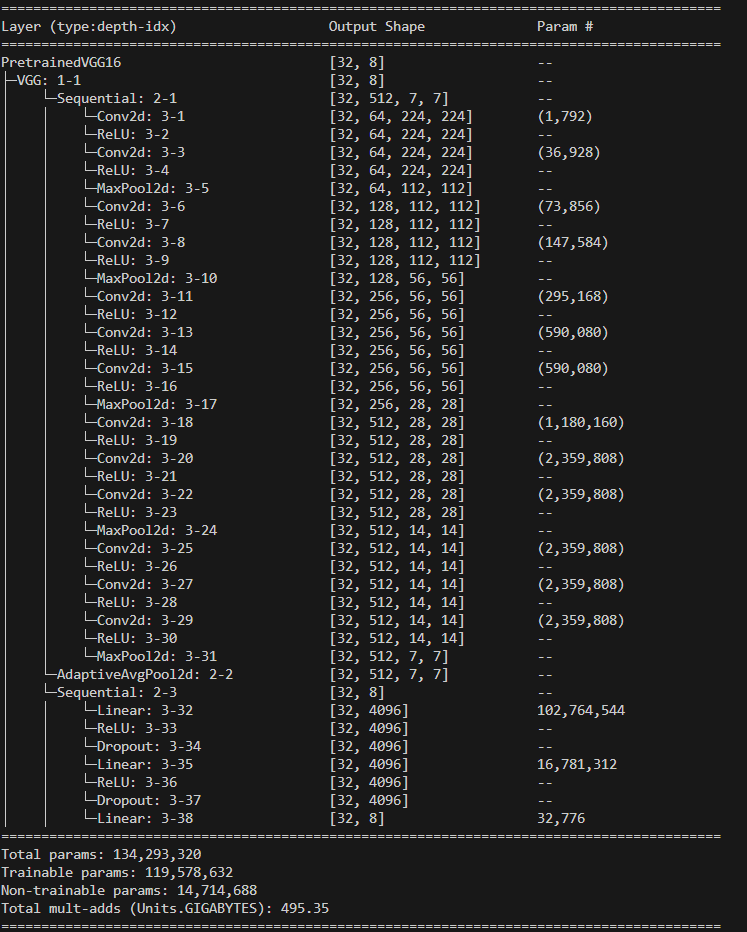

# Image Classification Model Comparison

This notebook compares three different models for image classification:
1. Multilayer Perceptron (MLP)
2. VGG16 implemented from scratch
3. Pretrained VGG16

We'll train each model, evaluate their performance, and visualize the results.

Tensorboard uses tensorflow, tensorboardX uses pytorch.

In [1]:
%pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.1 MB/s eta 0:00:00


## Imports

I like that you can import everything all at once here. Cool stuff.

In [2]:
# Import necessary libraries
from torch import nn, cuda, optim, no_grad, max, save, load
from torch import device as TorchDevice
from torch.amp import GradScaler, autocast

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models, datasets, transforms
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_absolute_error
from tensorboardX import SummaryWriter

import torch
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')

import seaborn as sns
import os
import re

## Base Hyperparameter Configuration (See further down)

In [3]:
from enum import Enum

class ModelType(Enum):
    MLP = 0 # Multilayer Perceptron model
    VGG16 = 1 # VGG16 CNN model from scratch
    VGG16_TORCH = 2 # Pytorch VG166 CNN model (pretrained)

class ModelMode(Enum):
    INFERENCE = 0
    TRAINING = 1

class OptimizerType(Enum):
    SGD = 0 # Stochastic Gradient Descent (SGD)
    ADAM = 1

hyperparameters: dict = {
    "batch_size": 32,
    "val_test_split": [0.2, 0.1], # 20% validation, 10% testing
    "model_type": ModelType.VGG16,
    "hidden_layers": [512, 256], # Only used in MLP
    "dropout_rate": 0.5,
    "learning_rate": 1e-5,
    "weight_decay": 1e-5,
    "num_epochs": 100,
    "optim_type": OptimizerType.ADAM,
}

CURRENT_MODEL_MODE = ModelMode.TRAINING

## Utility Functions and Global Variables

Some various bits and bobs.

In [4]:
import datetime
from pathlib import Path

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3

BASE_DIR = os.path.abspath(os.path.dirname(os.getcwd()))
LOG_DIR = os.path.abspath(os.path.join(BASE_DIR, "logs"))
MODEL_DIR = os.path.abspath(os.path.join(BASE_DIR, "models"))
CHECKPOINT_DIR = os.path.abspath(os.path.join(MODEL_DIR, "checkpoints"))
DATA_DIR = os.path.abspath(os.path.join(BASE_DIR, "data"))
FASHION_DATA_DIR = os.path.abspath(os.path.join(DATA_DIR, "fashion"))

# Ensure necessary directories exist
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

def check_cuda():
    if cuda.is_available():
        print("CUDA is available")
        print(f"CUDA device count: {cuda.device_count()}")
        print(f"Current CUDA device: {cuda.current_device()}")
        print(f"CUDA device name: {cuda.get_device_name(0)}\n")
    else:
        print("CUDA is not available, using CPU\n")

def save_state(state, model_file: str):
    model_path = os.path.abspath(os.path.join(CHECKPOINT_DIR, model_file))

    save(state, model_path)

def load_state(model_file: str, checkpoint: bool = True):
    if checkpoint:
        checkpoint_path = os.path.abspath(os.path.join(CHECKPOINT_DIR, model_file))
        return load(checkpoint_path, map_location="cpu", weights_only=True)
    else:
        model_path = os.path.abspath(os.path.join(MODEL_DIR, model_file))
        return load(model_path, map_location="cpu", weights_only=True)

def get_best_state() -> str | None:
    # Regex to match pattern
    pattern = r'ep=(\d+)_tl=([\d.]+)_vl=([\d.]+)_va=([\d.]+)\.pth'

    vl_min = float('inf')
    best_state: str = None

    for filename in list_files(CHECKPOINT_DIR):
        # Remove directory path
        basename = os.path.basename(filename)

        match = re.match(pattern, basename)

        if match:
            epoch = int(match.group(1))
            train_loss = float(match.group(2))
            validation_loss = float(match.group(3))
            validation_accuracy = float(match.group(4))

            if (validation_loss < vl_min):
                vl_min = validation_loss
                best_state = filename

    return best_state

def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, val_accuracy):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy
    }

    save_state(checkpoint, f"ep={epoch}_tl={train_loss:.4f}_vl={val_loss:.4f}_va={val_accuracy:.2f}.pth")

    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = load_state(checkpoint_path)

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    epoch = checkpoint["epoch"]
    train_loss = checkpoint["train_loss"]
    val_loss = checkpoint["val_loss"]
    val_accuracy = checkpoint["val_accuracy"]

    print(f"Loaded checkpoint from epoch {epoch} with train loss {train_loss:.4f}, validation loss {val_loss:.4f}, and accuracy {val_accuracy:.2f}%")

    return epoch

def get_log_dir():
    base_dir = os.path.join(LOG_DIR, "runs")
    time_str = datetime.datetime.now().strftime("%d-%m-%Y--%H-%M-%S")

    # Create the params string
    params = "-".join(f"{key}={value}" for key, value in hyperparameters.items())

    # Join params and time_str
    run_id = f"{params}--{time_str}"

    return os.path.join(base_dir, run_id)

def file_exists(filepath: str) -> bool:
    return os.path.isfile(filepath)

def directory_exists(file_dir: str) -> bool:
    return os.path.isdir(file_dir)

def list_files(file_dir: str):
    path = Path(file_dir)

    return [str(file) for file in path.rglob('*') if file.is_file()]

##Run this command to unzip fashion data folder after manually uploading to Google Colab.

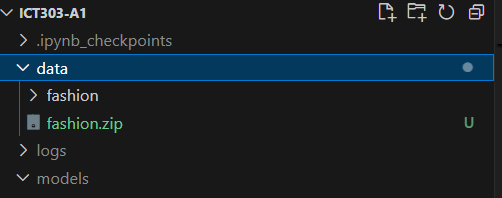

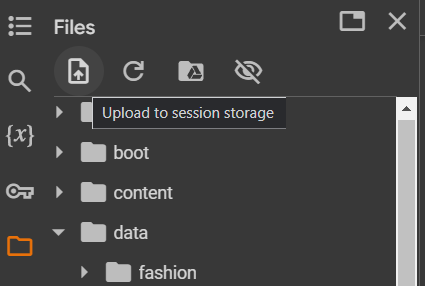

In [6]:
%mv ./content/fashion.zip ../data/
%cd ./data/
!unzip -o -q fashion.zip
%cd ..

/data
/


You should now see the fashion zip file successfully extracted in the data folder

## Data Loading and Preprocessing

When deciding the mean and standard deviation for the compose transforms, I just saw that using imagenet stats would be the smartest decision since it's based on a very large dataset of various images. (Fashion being one of them).

I made separate transforms for the training data and the validation + testing data.

Training data benefits from augmentation to increase diversity (randomness), prevent overfitting, and improve generalisation.

In [7]:
class ImageDataset(Dataset):
    def __init__(self,
                 root_dir : str,
                 img_size: int = 224,
                 mean: list = [0.485, 0.456, 0.406],
                 std: list = [0.229, 0.224, 0.225],
                 val_split: float = 0.2,
                 test_split: float = 0.1,
                 random_seed: int = 42):

        self.root_dir = root_dir

        self.img_size = img_size
        self.mean = mean
        self.std = std

        self.val_split = val_split
        self.test_split = test_split

        # 42 is the meaning of everything
        self.random_seed = random_seed

        self._compose_transforms()

        torch.manual_seed(self.random_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(self.random_seed)

        self.full_dataset = datasets.ImageFolder(self.root_dir)
        self.train_indices, self.val_indices, self.test_indices = self._stratified_split()

        self.train_dataset = Subset(self.full_dataset, self.train_indices)
        self.train_dataset.dataset.transform = self.train_transform

        self.val_dataset = Subset(self.full_dataset, self.val_indices)
        self.val_dataset.dataset.transform = self.eval_transform

        self.test_dataset = Subset(self.full_dataset, self.test_indices)
        self.test_dataset.dataset.transform = self.eval_transform

        self.class_names = self.full_dataset.classes

        self.diagnose_dataset()

    def _compose_transforms(self):
        # Training transforms
        self.train_transform = transforms.Compose([
            # Resize the image to a fixed size (ensure consistent input size)
            transforms.Resize((self.img_size, self.img_size)),
            # Randomly flip the image horizontally
            transforms.RandomHorizontalFlip(),
            # Randomly rotate the image by up to 20 degrees
            transforms.RandomRotation(20),
            # Randomly change the brightness, contrast, and saturation
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            # Convert the image to a PyTorch tensor
            transforms.ToTensor(),
            # Normalize the image (using ImageNet stats)
            transforms.Normalize(mean=self.mean, std=self.std)
        ])

        # Validation and Test transforms (no augmentation)
        self.eval_transform = transforms.Compose([
            # Resize the image to a fixed size
            transforms.Resize((self.img_size, self.img_size)),
            # Convert the image to a PyTorch tensor
            transforms.ToTensor(),
            # Normalize the image (using ImageNet stats)
            transforms.Normalize(mean=self.mean, std=self.std)
        ])

    def _stratified_split(self):
        labels = [label for _, label in self.full_dataset.samples]

        # Split off test set
        train_val_indices, test_indices = train_test_split(
            range(len(self.full_dataset)),
            test_size=self.test_split,
            stratify=labels,
            random_state=self.random_seed
        )

        # Split remaining data into train and validation sets
        train_val_labels = [labels[i] for i in train_val_indices]
        train_indices, val_indices = train_test_split(
            train_val_indices,
            test_size=self.val_split / (1 - self.test_split),
            stratify=train_val_labels,
            random_state=self.random_seed
        )

        return train_indices, val_indices, test_indices

    # I need more workers (quicker :D)
    def get_dataloaders(self, batch_size=32, num_workers=4):
        train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
        val_loader = DataLoader(self.val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
        test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

        return train_loader, val_loader, test_loader

    def diagnose_dataset(self):
        train_labels = [self.full_dataset.targets[i] for i in self.train_indices]
        val_labels = [self.full_dataset.targets[i] for i in self.val_indices]
        test_labels = [self.full_dataset.targets[i] for i in self.test_indices]

        print("\nDataset Summary:\n")
        print(f"Total samples: {len(self.full_dataset)}")
        print(f"Training samples: {len(self.train_dataset)} ({len(self.train_dataset) / len(self.full_dataset) * 100.0:.2f}%)")
        print(f"Validation samples: {len(self.val_dataset)} ({len(self.val_dataset) / len(self.full_dataset) * 100.0:.2f}%)")
        print(f"Test samples: {len(self.test_dataset)} ({len(self.test_dataset) / len(self.full_dataset) * 100.0:.2f}%)")

        print("\nClass distribution:")
        for split_name, labels in [("Training", train_labels), ("Validation", val_labels), ("Test", test_labels)]:
            label_counts = Counter(labels)
            print(f"\n{split_name} set:")
            for class_idx, class_name in enumerate(self.class_names):
                count = label_counts.get(class_idx, 0)
                percentage = (count / len(labels)) * 100
                print(f"Class {class_idx} ({class_name}): {count} ({percentage:.2f}%)")

## Model Definitions

Have hidden layers in MLP become a list of modules which are then put into a sequential neural network.

All models (parameters and weights) are sent to the GPU (if a cuda device is detected).

VGG16 consists of 5 convolutional blocks that make up 2 or more convolutional layers with max pooling. These layers all have 3x3 sized kernal filters and

Block 1: 2 conv layers + max pooling
Block 2: 2 conv layers + max pooling
Block 3: 3 conv layers + max pooling
Block 4: 3 conv layers + max pooling
Block 5: 3 conv layers + max pooling

In [8]:
from typing import List

class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_layers: List[int],
                 num_classes: int,
                 dropout_rate: float,
                 device: str = "cuda" if cuda.is_available() else "cpu"):
        super(MLP, self).__init__()

        layers = []
        in_features = input_size
        layers.append(nn.Flatten())
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.LayerNorm(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

            in_features = hidden_size

        layers.append(nn.Linear(in_features, num_classes))
        self.net = nn.Sequential(*layers)

        self.device = TorchDevice(device)
        self.to(self.device)

    ## Forward step
    def forward(self, X):
        # Compute output given an input X
        return self.net(X)

class VGG16(nn.Module):
    def __init__(self,
                 num_classes: int,
                 dropout_rate: float,
                 device: str = "cuda" if cuda.is_available() else "cpu"):
        super(VGG16, self).__init__()

        layers = []

        self._conv_block(layers, 3, 64, 2), # 2 x conv layers (2)
        self._conv_block(layers, 64, 128, 2), # 2 x conv layers (4)
        self._conv_block(layers, 128, 256, 3), # 3 x conv layers (7)
        self._conv_block(layers, 256, 512, 3), # 3 x conv layers (10)
        self._conv_block(layers, 512, 512, 3), # 3 x conv layers (13)

        self.encoder = nn.Sequential(*layers)

        self.avg_pool = nn.AdaptiveAvgPool2d((7,7))

        self.classifier = nn.Sequential(
            nn.Flatten(),
                # FC layer 1
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
                # FC layer 2
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
                # FC layer 3 (Output layer)
            nn.Linear(4096, num_classes),
        )

        self.device = TorchDevice(device)
        self.to(self.device)

    def _conv_block(self, layers, in_channels, out_channels, num_convs):

        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels

        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))


    def forward(self, X):
        x = self.encoder(X)
        x = self.avg_pool(x)
        x = self.classifier(x)

        return x

class PretrainedVGG16(nn.Module):
    def __init__(self,
                 num_classes: int,
                 device: str = "cuda" if cuda.is_available() else "cpu"):
        super(PretrainedVGG16, self).__init__()

        # Load pretrained VGG16 model
        self.vgg16 = models.vgg16(pretrained=True)

        # Freeze the features layers
        for param in self.vgg16.features.parameters():
            param.requires_grad = False

        # Replace the last fully connected layer
        num_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_features, num_classes)

        self.device = TorchDevice(device)
        self.to(self.device)

    def forward(self, X):
        return self.vgg16(X)

## Training Functions

I use mixed precision since it provides faster performance speeds and reduces memory usage without sacrificing the accuracy too much.

Mixed precision is used through autocast (when code is wrapped around it) which allows for certain operations to run in a lower precision (usually float16 from float32).

An early stopper is used to automatically determine if a model's performance is degrading with no noticeable improvement over a period of epochs.

Early stoppers are useful as they prevent overfitting and avoid wasting resources on unnecessary training epochs.

I use tqdm to keep track of the training and validating batches per epoch. Plus it looks nice :)

In [17]:
from typing import Type, Optional
from tqdm import tqdm

import time

class EarlyStopper:
    def __init__(self, patience: int = 7, min_delta: float = 0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_state = None

    def __call__(self, val_loss, model_state):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_state = model_state
        else:
            self.counter += 1
            self.countdown = self.patience - self.counter
            print(f"Epochs remaining before stopping early: {self.countdown}")
            if self.counter >= self.patience:
                self.early_stop = True
        return self.best_state

class Trainer():
    def __init__(self,
                 n_epochs: int,
                 lr: float,
                 weight_decay: float,
                 criterion: Type[nn.Module] = nn.CrossEntropyLoss,
                 patience: int = 3,
                 mixed_precision: bool = True,
                 device: str = "cuda" if cuda.is_available() else "cpu",
                 writer: Optional[Type[SummaryWriter]] = None):

        self.max_epochs = n_epochs
        self.criterion = criterion()
        self.lr = lr
        self.weight_decay = weight_decay
        self.patience = patience
        self.mixed_precision = mixed_precision
        self.device = device
        self.writer = writer
        self.save_frequency = 3

        self.early_stopper = EarlyStopper(patience=self.patience * 2, min_delta=1e-4)
        self.scaler = GradScaler() if self.mixed_precision else None

    ## Optimization algorithm
    def configure_optimizers(self, model_params, optim_type: OptimizerType):

        optimizer = None

        if optim_type == OptimizerType.SGD:
            optimizer = optim.SGD(params=model_params, lr=self.lr, momentum=0.9,
                                  weight_decay=self.weight_decay, nesterov=True)
        elif optim_type == OptimizerType.ADAM:
            optimizer = optim.Adam(params=model_params, lr=self.lr,
                                   weight_decay=self.weight_decay)

        # reduce the learning rate if the model's performance is shit
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                         factor=0.5,
                                                         patience=self.patience,
                                                         min_lr=1e-6)

        return optimizer, scheduler

    ## Fitting step
    def fit(self, model, train_loader: DataLoader, val_loader: DataLoader, optim_type: OptimizerType, pretrained: bool = True):
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader

        # Configure the optimizer
        self.optimizer, self.scheduler = self.configure_optimizers(self.model.parameters(), optim_type=optim_type)

        if pretrained:
            # Get the filepath of the best checkpoint state
            best_state = get_best_state()

            if best_state is not None:
                self.checkpoint = load_checkpoint(self.model, self.optimizer, best_state)

        best_val_loss = float('inf')
        start_time = time.time()

        for epoch in range(self.max_epochs):
            print(f"\nGPU Memory: Allocated: {cuda.memory_allocated() / 1e9:.2f} GB, "
              f"Cached: {cuda.memory_reserved() / 1e9:.2f} GB")

            train_loss = self.fit_epoch()
            val_loss, val_accuracy = self.validate()

            print(f"Epoch {epoch}/{self.max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%\n")

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            current_lr = self.scheduler.get_last_lr()[0]
            print(f"Current learning rate: {current_lr:.2e}")

            if self.writer is not None:
                # Log to TensorBoardX
                self.writer.add_scalar("Loss/Train", train_loss, epoch)
                self.writer.add_scalar("Loss/Validation", val_loss, epoch)
                self.writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)
                self.writer.add_scalar("Learning_Rate", current_lr, epoch)

            # Save best model if the validation loss is less than the current lowest val loss.
            # Also, the best model is saved every 3 or 5 epochs (depends what the save frequency is)
            if val_loss < best_val_loss:
                best_val_loss = val_loss

                if epoch % self.save_frequency == 0:
                    save_checkpoint(self.model, self.optimizer,
                                    epoch, train_loss=train_loss,
                                    val_loss=val_loss, val_accuracy=val_accuracy)

            best_state = self.early_stopper(val_loss, self.model.state_dict())
            if self.early_stopper.early_stop:
                print(f"Early stopping triggered at epoch {epoch}")
                self.model.load_state_dict(best_state)
                break

        end_time = time.time()
        print(f"\nTraining process has finished. Total time: {end_time - start_time:.2f} seconds")

    def fit_epoch(self):
        total_loss = 0.0
        num_batches = 0

        self.model.train()
        progress_bar = tqdm(self.train_loader, desc="Training", leave=False)
        # Iterate and update network weights, compute loss
        for inputs, labels in progress_bar:
            # Get inputs and the corresponding labels, move tensors to configured device
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            # Clear gradient buffers
            self.optimizer.zero_grad()

            # Forward pass
            with autocast(device_type=self.model.device.type, enabled=self.mixed_precision):
                # Get output from model, given the inputs
                outputs = self.model(inputs)

                # Get loss for predicted outputs
                loss = self.criterion(outputs, labels)

            # Backward and optimize (backpropigation)
            if self.mixed_precision:
                self.scaler.scale(loss).backward()
                # self.scaler.unscale_(self.optimizer)
                # nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                # Get gradients W.R.T the parameters of the model
                loss.backward()
                # nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()

            total_loss += loss.item()
            num_batches += 1

            # Update progress bar
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

            del inputs, labels, outputs

        return total_loss / num_batches

    def validate(self):
        total_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(self.val_loader, desc="Validating", leave=False)

        self.model.eval()
        with no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                with autocast(device_type=self.model.device.type, enabled=self.mixed_precision):
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)

                total_loss += loss.item()

                _, predicted = max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Update progress bar
                current_accuracy = 100 * correct / total
                progress_bar.set_postfix({
                    "loss": f"{total_loss / (progress_bar.n + 1):.4f}",
                    "accuracy": f"{current_accuracy:.2f}%"
                })

                del inputs, labels, outputs

        val_loss = total_loss / len(self.val_loader)
        accuracy = 100 * correct / total

        return val_loss, accuracy

## Evaluation Functions

In [10]:
def evaluate_model(model, test_loader):
    all_predictions = []
    all_labels = []

    model.eval()
    with no_grad(), autocast(device_type=model.device.type, enabled=True):
        # Evaluation on the entire test set
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            outputs = model(images.to(model.device))
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Compute metrics
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    mae = mean_absolute_error(all_labels, all_predictions)

    return conf_matrix, mae

## Results Visualization and Analysis

In [11]:
%load_ext tensorboard

def visualize_results(model, test_loader, conf_matrix, mae, writer: SummaryWriter):
    # Print results
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print(f"Shape of confusion matrix: {conf_matrix.shape}")

    print(f"\nMean Absolute Error: {mae:.4f}")

    # Log to TensorBoardX
    writer.add_scalar("Test/MAE", mae)

    # Create and log confusion matrix
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", square=True, cbar=True, ax=ax)
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    plt.tight_layout()

    writer.add_figure("Confusion Matrix", fig)
    plt.close(fig)

    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    images = images.to(model.device)

    writer.add_graph(model, images)

## Adjust hyperparameters as needed

In [18]:
hyperparameters["batch_size"] = 32
hyperparameters["model_type"] = ModelType.VGG16_TORCH
hyperparameters["hidden_layers"] = [512, 256] # MLP model only
hyperparameters["learning_rate"] = 1e-2
hyperparameters["weight_decay"] = 1e-9
hyperparameters["optim_type"] = OptimizerType.SGD

CURRENT_MODEL_MODE = ModelMode.TRAINING

## Main Calling Function

In [ ]:
%tensorboard --logdir logs

In [ ]:
def main() -> int:
    check_cuda()

    # Load the dataset
    dataset = ImageDataset(FASHION_DATA_DIR,
                           val_split=hyperparameters.get("val_test_split")[0],
                           test_split=hyperparameters.get("val_test_split")[1])
    train_loader, val_loader, test_loader = dataset.get_dataloaders(batch_size=hyperparameters.get("batch_size"), num_workers=2)

    num_classes = len(dataset.class_names)

    log_dir = get_log_dir()

    model = None

    # Create the model
    match hyperparameters.get("model_type"):
        case ModelType.MLP:
            model = MLP(3 * 224 * 224,
                        hidden_layers=hyperparameters.get("hidden_layers"),
                        num_classes=num_classes,
                        dropout_rate=hyperparameters.get("dropout_rate"))
        case ModelType.VGG16:
            model = VGG16(num_classes=num_classes,
                          dropout_rate=hyperparameters.get("dropout_rate"))
        case ModelType.VGG16_TORCH:
            model = PretrainedVGG16(num_classes=num_classes)

    # summary(model, input_size=(hyperparameters.get("batch_size"), IMAGE_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
    writer = SummaryWriter(log_dir=log_dir)

    if CURRENT_MODEL_MODE is ModelMode.TRAINING:
        # Create the trainer
        trainer = Trainer(n_epochs=hyperparameters.get("num_epochs"),
                        lr=hyperparameters.get("learning_rate"),
                        weight_decay=hyperparameters.get("weight_decay"),
                        device=model.device, writer=writer)

        # Train the model to fit the parameters
        trainer.fit(model=model, train_loader=train_loader, val_loader=val_loader, optim_type=hyperparameters.get("optim_type"), pretrained=False)

        # Evaluate the effectiveness of the model
        conf_matrix, mae = evaluate_model(model=model, test_loader=test_loader)
        visualize_results(model, test_loader, conf_matrix, mae, writer=writer)
    elif CURRENT_MODEL_MODE is ModelMode.INFERENCE:
        model_state = load_state("best.pth", checkpoint=False)
        model.load_state_dict(model_state["model_state_dict"])

        # Evaluate the effectiveness of the model
        conf_matrix, mae = evaluate_model(model=model, test_loader=test_loader)
        visualize_results(model, test_loader, conf_matrix, mae, writer=writer)

    writer.flush()
    writer.close()

    return 0

if __name__ == "__main__":
  main()

##How do Hyperparameters affect performance?

###Learning Rate:

* Too high: Can cause unstable training, and overshoot optimal values.
* Too low: Can result in slow convergence.
* Optimal: Allows for efficient convergence to a good solution.


###Batch Size:

* Larger: More stable gradient estimates, but might lead to poorer generalization.
* Smaller: More noisy updates, but slower training.

###Network Architecture (e.g., number and size of layers):

* Too simple: May underfit, unable to capture complex patterns.
* Too complex: May overfit, especially with limited data.


###Dropout Rate:

* Higher: Stronger regularization, helps prevent overfitting but might impede learning.
* Lower: Less regularization, might allow overfitting but potentially better performance on training data.


###Weight Decay (L2 Regularization):

* Stronger: Helps prevent overfitting but might restrict the model too much.
* Weaker: Allows more flexibility but increases the risk of overfitting.


###Optimizer Choice:

* SGD: Often requires more tuning but can achieve excellent results.
* Adam: Can converge faster and require less tuning, but might generalize slightly worse in some cases.

###Number of Filters/Neurons:

* More filters/neurons: Can capture more complex patterns but increase computational cost and risk of overfitting.
* Fewer filters/neurons: More computationally efficient but might underfit.


###Data Augmentation Parameters:

* Strong augmentation: Can improve generalization but might make training more difficult.
* Weak augmentation: Easier training but might not provide as much benefit for generalization.


###Early Stopping Patience:

* Too short: Might stop training prematurely.
* Too long: Might allow overfitting.

#Best Performing Model Results
##Multilayer Perceptron (MLP)
###Hyperparameters

*   Batch Size: 32 - (64 is also a viable option given the amount of GPU memory available)
* Hidden Layers: [256, 128] - (Also found that [512, 256] works great too).
  
  * Computers like numbers in the power of 2.

  * Two hidden layers with activation functions provide more depth than a single layer, but not so deep as to risk severe overfitting or making training really slow.

  * The gradual reduction in layer sizes was the most common thing I noticed in other MLP models I saw online.
*   Learning Rate: Between 0.01 and 0.001 was the most optimal starting lr
*   Optimizer: I found that SGD with 0.9 momentum gave better generalisation, although Adam was quicker to converge.

## VGG16 (from scratch)
###Hyperparameters
*   Batch Size: 32 - (64 is also a viable option given the amount of GPU memory available)
*   Learning Rate: Between 0.01 and 0.001 was the most optimal starting lr
*   Optimizer: I found that SGD with 0.9 momentum gave better generalisation, although Adam was quicker to converge.

## VGG16 (Pytorch provided)
###Hyperparameters
*   Batch Size: 32 - (64 is also a viable option given the amount of GPU memory available)
*   Learning Rate: Between 0.01 and 0.001 was the most optimal starting lr
*   Optimizer: I found that SGD with 0.9 momentum gave better generalisation, although Adam was quicker to converge.